In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig1_plots

import analysis_rnn as rnn
import analysis_neuro as spk
import basic_analysis as basic
import model_utils
import dim_alignment as dim
from task import generate_batch

from scipy import stats
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance as dist

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_2map/"
save_folder = f"../figures/fig1_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

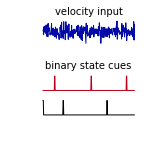

In [5]:
''' Figure 1E: inputs '''
f, gs = fig1_plots.plot_e(inputs["inp_vel"],\
                          inputs["inp_remaps"])
plt.show()
f.savefig(f'{save_folder}inputs.png', dpi=600, bbox_inches='tight')

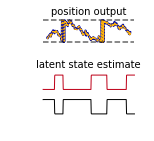

In [6]:
''' Figure 1F: outputs'''
f, gs = fig1_plots.plot_f(targets["pos_targets"],\
                          outputs["pos_outputs"],\
                          outputs["map_logits"])
plt.show()
f.savefig(f'{save_folder}outputs.png', dpi=600, bbox_inches='tight')

mean +/- standard deviation:
position loss: 0.0105 +/- 0.00145
context loss: 0.00179 +/- 0.000123


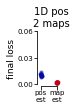

RMS angular error after 301 steps (mean, stdv) = 8.13, 0.508
percent correct state estimates (mean, stdv) = 100.0, 0.0


In [4]:
''' summary performance across models '''
# loss
f, ax = fig1_plots.plot_supp_1(data_folder, model_IDs)
ax.set_title('1D pos\n2 maps', fontsize=10, pad=5)
plt.show()

# other performance metrics
pos_error_deg, pct_correct = fig1_plots.performance_metrics(data_folder, model_IDs)

NameError: name 'axis_label' is not defined

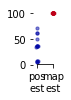

In [57]:
# figure params
f, ax = plt.subplots(1, 1, figsize=(0.5, 1))
pos_col = 'xkcd:cobalt blue'
c1 = 'xkcd:scarlet'
DOT_SIZE = 10
DOT_LW = 1

# for jittering points
JIT = np.random.randn(n_models) * 0.03

# 1 = pos loss, 2 = map loss
ax.scatter(np.full(n_models, 1)+JIT, 
           pos_error_deg,
           c=pos_col,
           s=DOT_SIZE, lw=DOT_LW,
           alpha=0.5
          )
ax.scatter(np.full(n_models, 2)+JIT, 
           pct_correct,
           c=c1,
           s=DOT_SIZE, lw=DOT_LW,
           alpha=0.5
          )

# axis params
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(0, 0.06)
ax.spines['bottom'].set_bounds(1, 2)

ax.set_xlim([0.75, 2.5])
# ax.set_ylim([-0.002, 0.05])
ax.set_xticks([1, 2])
ax.set_xticklabels(['pos\nest', 'map\nest'])
# ax.set_yticks([0, 0.03, 0.06])
ax.set_ylabel('final loss', fontsize=axis_label, labelpad=1)

ax.tick_params(which='major', labelsize=tick_label, pad=0.5)

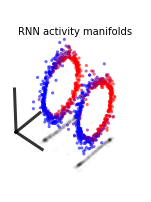

In [9]:
''' Figure 1H: aligned ring manifolds '''
f, ax = fig1_plots.plot_h(X, pos_targ)
plt.show()
f.savefig(f'{save_folder}manifolds.png', dpi=600, bbox_inches='tight')

mean alignment = 0.6
sem misalignment = 0.0088


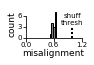

In [10]:
''' Figure 1I: summary of ring alignment '''
f, ax = fig1_plots.plot_j(data_folder, model_IDs)
f.savefig(f'{save_folder}alignment.png', dpi=600, bbox_inches='tight')
plt.show()

on average, 3 PCs explain 54.71% of the variance
on average, 12 PCs explain 90.07% of the variance


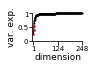

In [8]:
''' Figure 1J: summary of dimensionality '''
f, axes = fig1_plots.plot_i(data_folder, model_IDs,
                            top_num=3, top_num_1=2)
plt.show()
f.savefig(f'{save_folder}PCs_all.png', dpi=600, bbox_inches='tight')

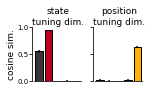

In [7]:
''' Figure 1K: alignment to remapping dim and position subspace '''
f, ax = fig1_plots.plot_k(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}dim_angles.png', dpi=600, bbox_inches='tight')

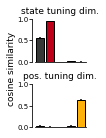

In [4]:
''' Figure 1K alt for supplement '''
f, ax = fig1_plots.plot_supp1b(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}dim_angles_alt.png', dpi=600, bbox_inches='tight')

630 total track traversals
59.0 total remapping events


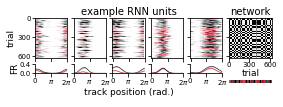

In [6]:
''' plot figure 1G: RNN single unit examples & network similarity '''
f, gs = fig1_plots.plot_g(data_folder, model_IDs[ex_id])
plt.show()
f.savefig(f'{save_folder}ex_tuning_similarity.png', dpi=600, bbox_inches='tight')